# Basic Convolutional Neural Network (CNN)

Now that we've explored the data, figured out how it looks when loaded, and created a pipeline to transform it, we can actually assemble our first convolutional neural network.

## Table of Contents

* [What is a CNN](#what)
* [Basic CNN Architecture](#arch)
* [Building a CNN in Keras](#keras)

In [1]:
%matplotlib inline

import numpy as np
np.random.seed(1729)  # for reproducibility

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from scipy.misc import imresize 
import matplotlib.pylab as plt
from lfw_fuel import lfw

Using TensorFlow backend.


Start by defining the load-transform function, then loading the data.

In [2]:
def crop_and_downsample(originalX, downsample_size=32):
    """
    Starts with a 250 x 250 image.
    Crops to 128 x 128 around the center.
    Downsamples the image to (downsample_size) x (downsample_size).
    Returns an image with dimensions (channel, width, height).
    """
    current_dim = 250
    target_dim = 128
    margin = int((current_dim - target_dim)/2)
    left_margin = margin
    right_margin = current_dim - margin

    # newim is shape (6, 128, 128)
    newim = originalX[:, left_margin:right_margin, left_margin:right_margin]

    # resized are shape (feature_width, feature_height, 3)
    feature_width = feature_height = downsample_size
    resized1 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
    resized2 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")

    # re-packge into a new X entry
    newX = np.concatenate([resized1,resized2], axis=2)
    
    # the next line is EXTREMELY important.
    # if you don't normalize your data, all predictions will be 0 forever.
    newX = newX/255
    
    return newX

a = 0

In [3]:
# Load the data, shuffled and split between train and test sets
(X_train_original, y_train_original), (X_test_original, y_test_original) = lfw.load_data("deepfunneled")

<a name="what"></a>
## What is a CNN

A convolutional neural network, or CNN, is a particular type of neural network architecture that is useful for image recognition and classification tasks. It works by splitting up the image spatially, passing different portions of the image through different neurons, and using multiple layers to extract important features from particular regions of the image.

### Resources

Useful links from Dr. Jason Brownlee: 
* From Jason Brownlee:
    * [Convolutional neural networks](http://machinelearningmastery.com/crash-course-convolutional-neural-networks/)
    * [Object recognition with Keras](http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/)
    
* From Michael Nielsen:
    * [Book chaper](http://neuralnetworksanddeeplearning.com/chap6.html)

<a name="arch"></a>
## Basic CNN Architecture

Convolutional neural networks use three types of layers:
* Convolutional layers
* Pooling layers
* Fully connected layers

Convolutional layers are comprised of filters and feature maps. 
* Filters are the neurons of the layer, which have inputs, weights, and outputs. Input size is a fixed patch. For input convolutional layers, these patches are pixels striaght from the image. Deeper in the neural network, the patches are the outputs from prior layers.
* Feature maps are how outputs from one layer are connected to inputs at the next layer. 
* Padding is necessitated by the fact that one layer's output sie may not be cleanly divisible by the filter patch at the next layer. Zero padding can be used to keep the neural net from reading off the edge of the image.

Pooling layers down-sample a given layer.
* Pooling acts as a compression or dimensionality reduction, condensing the features learned in prior layers to the most important ones. Their input size is often much smaller than the convolutional layer they are connected to. 
* These create their own feature maps (how outputs from one layer are connected to inputs at the next layer), often using an average or maximum function.

Fully connected layers are used to combine the various extracted features.
* Fully connected layers create a non-linear combination of all incoming features.
* Activation functions at the connected layer is often a softmax or non-linear function. 
* These can be thought of as predicting the probability of a particular class or classification.

The general architecture of a convolutional neural network is:
* Convolution
* Convolution
* Pool
* Dropout
* Flatten
* Dense
* Dropout
* Dense

This can take other forms, like:
* Convolution
* Dropout
* Convolution
* Pool
* Flatten
* Dense/Fully connected
* Dropout
* Dense/Fully connected (n_classes)

Optionally, to add more convolution layers,
* Convolution (32 feature maps)
* Dropout
* Convolution (32 feature maps)
* Pool
* Convolution (64 feature maps)
* Dropout
* Convolution (64 feature maps)
* Pool
* Convolution (128 feature maps)
* Dropout
* Convolution (128 feature maps)
* Pool
* Flatten
* Dropout
* Dense/Fully connected (1024)
* Dropout
* Dense/Fully connected (512)
* Dropout
* Dense/Fully connected (n_classes)

<a name="keras"></a>
## Building a CNN in Keras

In Keras, it takes a little bit of effort to understand how to get all of the layers to line up. The comments in the neural network constructed below should explain what's happening at each step.

In [4]:
ds = 32
X_train = np.asarray([crop_and_downsample(x, downsample_size=ds) for x in X_train_original])
X_test  = np.asarray([crop_and_downsample(x, downsample_size=ds) for x in X_test_original])
y_train = y_train_original
y_test  = y_test_original

Last-minute sanity check of the data.

In [5]:
print(X_train.shape)
print(y_train.shape)

(2200, 32, 32, 6)
(2200, 1)


In [6]:
X_train[5,10:15,10:15,0:3]

array([[[ 0.40392157,  0.2745098 ,  0.25098039],
        [ 0.36078431,  0.25098039,  0.21960784],
        [ 0.40392157,  0.25098039,  0.24313725],
        [ 0.5254902 ,  0.34509804,  0.33333333],
        [ 0.62745098,  0.40392157,  0.41176471]],

       [[ 0.48627451,  0.37254902,  0.34117647],
        [ 0.41960784,  0.34117647,  0.30980392],
        [ 0.39607843,  0.27843137,  0.26666667],
        [ 0.42352941,  0.27058824,  0.24313725],
        [ 0.57647059,  0.36862745,  0.35686275]],

       [[ 0.24313725,  0.14901961,  0.11372549],
        [ 0.23921569,  0.16470588,  0.1372549 ],
        [ 0.40392157,  0.29019608,  0.28235294],
        [ 0.45098039,  0.29019608,  0.27058824],
        [ 0.61960784,  0.40392157,  0.39607843]],

       [[ 0.36862745,  0.2627451 ,  0.23529412],
        [ 0.38823529,  0.2627451 ,  0.24705882],
        [ 0.5254902 ,  0.38823529,  0.39215686],
        [ 0.52156863,  0.32156863,  0.33333333],
        [ 0.68235294,  0.44705882,  0.45882353]],

       [[ 0.

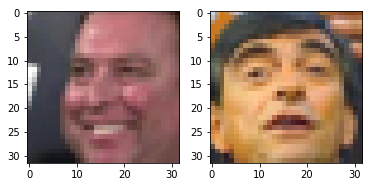

In [7]:
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(X_train[5,:,:,0:3])
ax2.imshow(X_train[5,:,:,3:6])
plt.show()

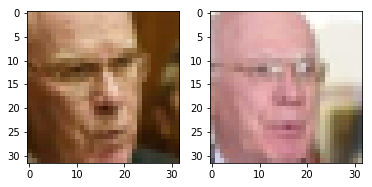

In [8]:
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(X_test[3,:,:,0:3])
ax2.imshow(X_test[3,:,:,3:6])
plt.show()

In [9]:
print(y_train.shape)
print("Zeros: %d"%(np.sum(y_train==0)))
print("Ones: %d"%(np.sum(y_train==1)))

(2200, 1)
Zeros: 1100
Ones: 1100


In [10]:
print(y_test.shape)
print("Zeros: %d"%(np.sum(y_test==0)))
print("Ones: %d"%(np.sum(y_test==1)))

(1000, 1)
Zeros: 500
Ones: 500


In [11]:
modelA = Sequential()

# Convolutional input layer:
# - 20 feature maps (each feature map is a reduced-size convolution that detects a different feature)
# - 3 pixel square window
modelA.add(Conv2D(32, (5,5),
                  input_shape=(ds,ds,6),
                  padding='same',
                  data_format='channels_last',
                  activation='relu'))

# Second convolutional layer
# - 40 feature maps (add more features)
# - 3 pixel square window
modelA.add(Conv2D(32, (5,5),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer
modelA.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Set X% of units to 0
modelA.add(Dropout(0.2))

# Flatten layer.
modelA.add(Flatten())

# Fully connected layer with 128 units and a rectifier activation function.
modelA.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))

# Dropout set to 50%.
modelA.add(Dropout(0.5))

# Fully connected output layer with 2 units (Y/N) 
# and a softmax activation function.
modelA.add(Dense(1, activation='sigmoid'))

print(modelA.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4832      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [12]:
# Compile model:
#modelA.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
modelA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [13]:
epochs = 25
batch_size = 128

modelA.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1,
           validation_data=(X_test, y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/25
2200/2200 [==============================] - 30s - loss: 0.7249 - binary_accuracy: 0.4827 - val_loss: 0.6959 - val_binary_accuracy: 0.5000
Epoch 2/25
2200/2200 [==============================] - 22s - loss: 0.6941 - binary_accuracy: 0.5114 - val_loss: 0.6931 - val_binary_accuracy: 0.5110
Epoch 3/25
2200/2200 [==============================] - 22s - loss: 0.6931 - binary_accuracy: 0.5086 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 4/25
2200/2200 [==============================] - 21s - loss: 0.6930 - binary_accuracy: 0.5114 - val_loss: 0.6930 - val_binary_accuracy: 0.5200
Epoch 5/25
2200/2200 [==============================] - 23s - loss: 0.6932 - binary_accuracy: 0.4986 - val_loss: 0.6930 - val_binary_accuracy: 0.4990
Epoch 6/25
2200/2200 [==============================] - 23s - loss: 0.6921 - binary_accuracy: 0.5259 - val_loss: 0.6924 - val_binary_accuracy: 0.5120
Epoch 7/25
2200/2200 [==============================

In [14]:
res1 = modelA.predict(X_train)
res2 = modelA.predict(X_test)

In [15]:
print("Training Data:")
print("Zeros: %d"%(np.sum(res1<0.5)))
print("Ones: %d"%(np.sum(res1>0.5)))
print("\n")
print("Testing Data:")
print("Zeros: %d"%(np.sum(res2<0.5)))
print("Ones: %d"%(np.sum(res2>0.5)))

Training Data:
Zeros: 1200
Ones: 1000


Testing Data:
Zeros: 571
Ones: 429


In [16]:
print(modelA.get_weights()[0])

[[[[ -7.30136558e-02  -2.62071043e-02  -7.98600614e-02 ...,
     -2.91530211e-02   5.75832464e-02   4.22419831e-02]
   [ -8.34471583e-02  -3.28144953e-02  -7.73690417e-02 ...,
      6.37232140e-02   3.78419906e-02  -2.85686180e-03]
   [ -3.13801016e-03   8.30350965e-02  -4.93413247e-02 ...,
      3.40682194e-02  -6.50123432e-02  -7.01055601e-02]
   [  4.20035720e-02  -8.54680017e-02  -8.77044052e-02 ...,
      5.43071665e-02  -4.36960571e-02  -3.73636512e-03]
   [ -9.68413278e-02   3.24992612e-02   3.53070535e-02 ...,
      7.40018999e-03   7.33177885e-02   4.56468761e-02]
   [ -1.00364186e-01  -2.84050591e-02  -5.06726839e-02 ...,
     -3.56203876e-02  -7.57855624e-02  -2.95370836e-02]]

  [[  3.31462957e-02  -9.40454900e-02   1.91586139e-03 ...,
     -1.02428232e-04   1.05878524e-02  -1.75930187e-02]
   [ -7.43806884e-02   4.54237200e-02   5.52915893e-02 ...,
     -8.71477649e-02  -7.46177956e-02   2.93580387e-02]
   [ -4.87211533e-02  -6.61595911e-02  -7.55968094e-02 ...,
      3.35

In [17]:
score = modelA.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: {0:%}'.format(score[1]))

Test accuracy: 68.300000%
